## Ajuste de los parámetros del modelo a datos reales de defunciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
plt.rcParams["font.family"] = "Tahoma"

In [2]:
from model import SEIRDmodel

Cargamos los datos que queremos usar (totales, por entidad, cdmx):

In [3]:
modelo = SEIRDmodel()

La siguiente línea de código es la que debería correrse para realizar el ajuste.

In [ ]:
ajuste = modelo.ajustar()

In [ ]:
ajuste

In [16]:
ajuste

array([5.40933899e-05, 1.34532255e-01, 4.15634408e-01, 2.21201177e-01,
       1.33731581e-01, 2.12129261e-01, 1.25683353e-01, 5.65876928e-01,
       2.46264808e-01])

In [17]:
with open('D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/results/ajuste8regiones.pkl', 'wb') as handle:
    pickle.dump(ajuste, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
ynor = modelo.simular()

In [13]:
modelo.poblaciones

array([1983890, 3209181, 4080608, 3252076, 2468139,  830660, 2642603,
       2406496], dtype=int64)

In [21]:
defunciones = ynor[[5*i + 4 for i in range(8)]]

In [57]:
acumcasos = casos.iloc[:, 1:].cumsum(axis = 1)

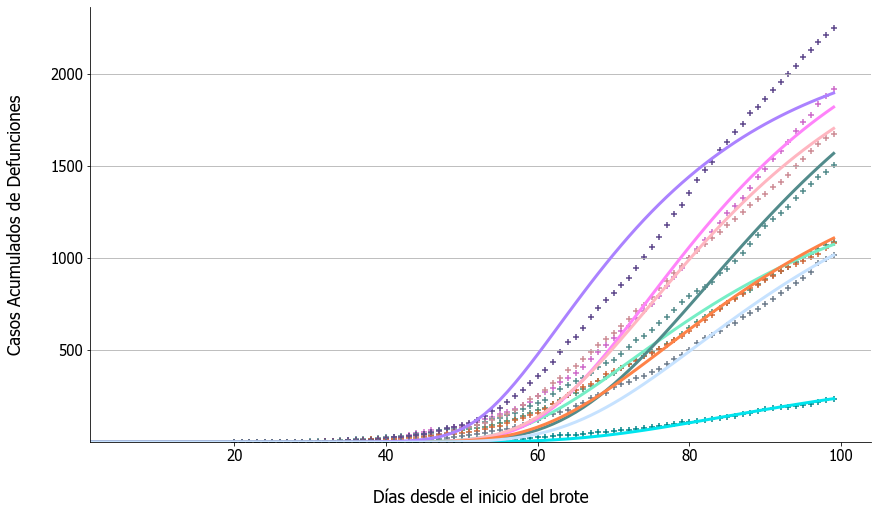

In [87]:
fig, ax = plt.subplots()

solid = ['#76EEC6', '#FF83FA', '#528B8B', '#FFB6C1', '#FF8247', '#00E5EE', '#AB82FF', '#C6E2FF']
dots = ['#458B74', '#CD69C9', '#528B8B', '#CD8C95', '#CD6839', '#00868B', '#5D478B', '#6C7B8B']

tsolid = np.linspace(0, 99, 100)
tdots = np.linspace(20, 99, 80)

for i, _ in enumerate(defunciones):
    ax.plot(tsolid, _, label = 'I(t) en Region {}'.format(i+1), 
            linewidth = 3, color = solid[i])

for i in range(8):
    ax.scatter(tdots, acumcasos.iloc[i, 1:81], color = dots[i], label = 'casos reales Region {}'.format(i+1),
              marker = '+', )

ax.set_xlabel('\nDías desde el inicio del brote', fontsize = 17)
ax.set_ylabel('Casos Acumulados de Defunciones\n', fontsize = 17)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(axis = 'y')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlim(1)
ax.set_ylim(1)
fig.set_size_inches(14, 8)
plt.show()